In [1]:
import os
import pickle
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add


In [2]:
from google.colab import files
files.upload()  # select kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"namrahkhandurrani","key":"837302267d31f2c297ca141ed2967d15"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d adityajn105/flickr8k


Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 94% 998M/1.04G [00:04<00:00, 183MB/s]
100% 1.04G/1.04G [00:04<00:00, 239MB/s]


In [5]:
!unzip flickr8k.zip -d /content/flickr8k


Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: /content/flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: /content/flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: /content/flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: /content/flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: /content/flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: /content/flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/fli

In [6]:
BASE_DIR = '/content/flickr8k'
WORKING_DIR = '/kaggle/working'

##Extract Image Features

In [7]:
#load VGG model
model=VGG16()
#resturcture the model
model=Model(inputs=model.inputs,outputs=model.get_layer('fc2').output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
from tqdm.notebook import tqdm
features={}
directory=os.path.join(BASE_DIR,'Images')
for img_name in tqdm(os.listdir(directory)):
   #load img from file
   img_path=directory+'/'+img_name
   image=load_img(img_path,target_size=(224,224))
   #convert img pixels to numpy array
   image=img_to_array(image)
   #reshape data for model
   image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
   #preprocess image for vgg
   image=preprocess_input(image)
   #extract features
   image_features=model.predict(image,verbose=0)
   image_id=img_name.split(".")[0]
   features[image_id]=image_features

  0%|          | 0/8091 [00:00<?, ?it/s]

In [9]:
#store features in pickle
pickle.dump(features,open(os.path.join('./','features.pkl'),'wb'))
#load features from pickle
with open(os.path.join('./','features.pkl'),'rb') as f:
  features=pickle.load(f)

##load the caption data

In [10]:
with open(os.path.join(BASE_DIR,'/content/flickr8k/captions.txt'),'r') as f:
  next(f)
  caption_doc=f.read()


In [11]:
mapping={}
for line in tqdm(caption_doc.split('\n')):
  tokens=line.split(",")
  if len(line)<2:
    continue
  image_id,caption=tokens[0],",".join(tokens[1:]) # Fixed: Join the rest of the tokens as the caption
  image_id=image_id.split(".")[0]
  #caption=" ".join(caption) # This line is incorrect, caption is already a string
  if image_id not in mapping:
    mapping[image_id]=[]
  mapping[image_id].append(caption) # Fixed: Append caption to the list in the mapping dictionary

  0%|          | 0/40456 [00:00<?, ?it/s]

In [12]:
len(mapping)

8091

In [13]:
def clean(mapping):
  for key,captions in mapping.items():
      for i in range(len(captions)): # Iterate through the index of the captions list
         caption=captions[i] # Assign the current caption string to the variable 'caption'
         caption=caption.lower()
         # delete digits, special chars, etc.
         caption=caption.replace('[^A-Za-z]'," ")
          # delete additional spaces
         caption = caption.replace('\s+', ' ')
         #add start and end tag
         caption = 'start ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' end'
         captions[i]=caption # Update the caption in the list

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3540850740.py:9: SyntaxWarning: invalid escape sequence '\s'
  caption = caption.replace('\s+', ' ')


In [14]:
#before preprocess of the text
mapping[image_id]

['A man in a pink shirt climbs a rock face',
 'A man is rock climbing high in the air .',
 'A person in a red shirt climbing up a rock face covered in assist handles .',
 'A rock climber in a red shirt .',
 'A rock climber practices on a rock climbing wall .']

In [15]:
#preprocess the text
clean(mapping)

In [16]:
#after preprocess of text
mapping[image_id]

['start man in pink shirt climbs rock face end',
 'start man is rock climbing high in the air end',
 'start person in red shirt climbing up rock face covered in assist handles end',
 'start rock climber in red shirt end',
 'start rock climber practices on rock climbing wall end']

In [17]:
all_caption=[]
for key in mapping:
  for caption in mapping[key]:
    all_caption.append(caption)


In [18]:
len(all_caption)

40455

In [19]:
all_caption[:10]

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end',
 'start black dog and spotted dog are fighting end',
 'start black dog and tri-colored dog playing with each other on the road end',
 'start black dog and white dog with brown spots are staring at each other in the street end',
 'start two dogs of different breeds looking at each other on the road end',
 'start two dogs on pavement moving toward each other end']

In [20]:
#tokenize the text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_caption)
vocab_size=len(tokenizer.word_index)+1
vocab_size

8483

In [21]:
#max length of caption available
max_length=max(len(caption.split())for caption in all_caption)
max_length

35

##Train-Test Split

In [22]:
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.90)
train=image_ids[split:]
test=image_ids[:split]

In [23]:
#create data generator to get data in batch (avoids session crash)
def data_genrator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
  X1,X2,y=list(),list(),list()
  n=0
  while 1:
    for key in data_keys:
      n+=1
      captions=mapping[key]
      for caption in captions:
        seq=tokenizer.texts_to_sequences([caption])[0]
        for i in range(1,len(seq)):
          in_seq,out_seq=seq[:i],seq[i]
          in_seq=pad_sequences([in_seq],maxlen=max_length)[0]
          out_seq=to_categorical([out_seq],num_classes=vocab_size)[0]
          #store the sequence
          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
      if n==batch_size:
        X1,X2,y=np.array(X1),np.array(X2),np.array(y)
        yield ((X1, X2), y)
        #re-initialize
        X1,X2,y=list(),list(),list()
        n=0

##Create Model

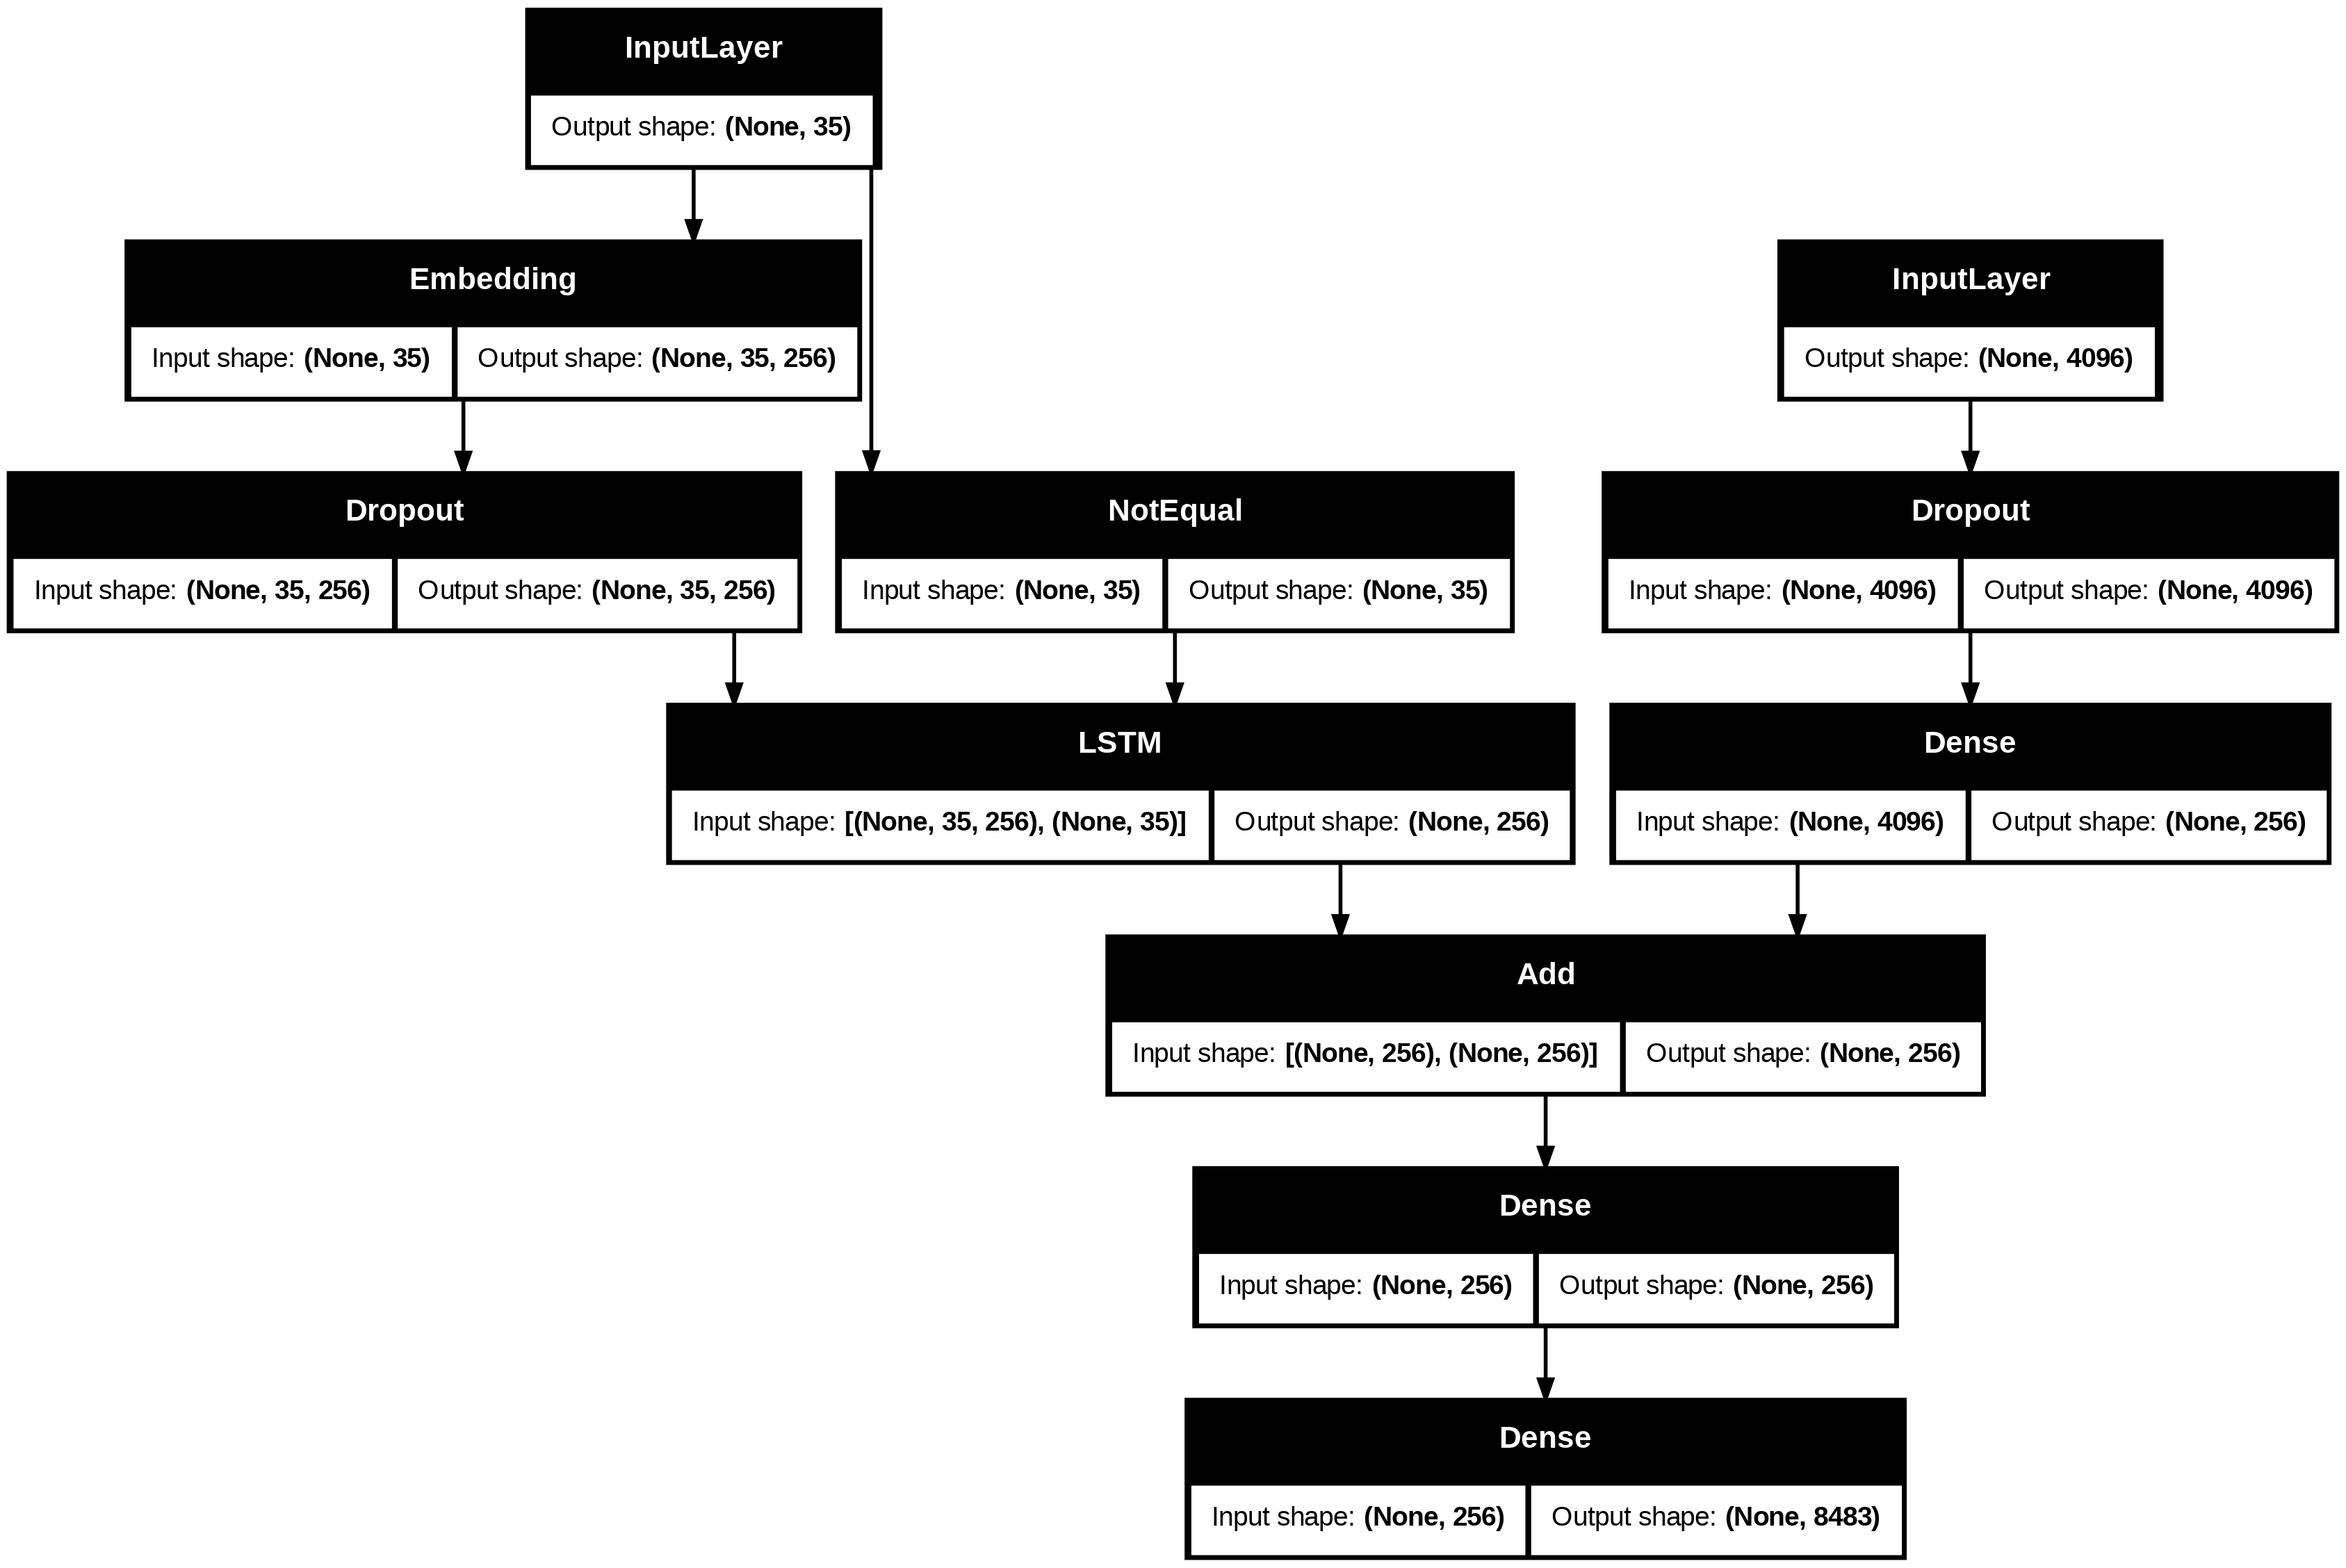

In [24]:
#ENCODER
#image faature layers
inputs1=Input(shape=(4096,))
fe1=Dropout(0.4)(inputs1)
fe2=Dense(256,activation='relu')(fe1)
#seq feature layers
inputs2=Input(shape=(max_length,))
se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256, use_cudnn=False)(se2) # Disable cuDNN
#DECODER
decoder1=add([fe2,se3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')
plot_model(model,show_shapes=True)

In [25]:
#Train the model
epochs=10
batch_size=64
steps=len(train)//batch_size

for i in range(epochs):
  data=data_genrator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
  #fit for one epochs
  model.fit(data,epochs=1,steps_per_epoch=steps,verbose=1)

  #save the model
  model.save(WORKING_DIR +'/best_model.h5')

12/12 ━━━━━━━━━━━━━━━━━━━━ 61s 5s/step - loss: 7.6203


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 531ms/step - loss: 5.7105


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 559ms/step - loss: 5.3903


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 534ms/step - loss: 5.0916


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 588ms/step - loss: 4.7943


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 541ms/step - loss: 4.5079


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 587ms/step - loss: 4.2275


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 588ms/step - loss: 3.9642


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 563ms/step - loss: 3.7447


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 633ms/step - loss: 3.5711


##Genrating Captions for Image

In [26]:
def idx_to_word(integer,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index==integer:
      return word
  return None

In [27]:
#genrate caption for image
def predict_caption(model,image,tokenizer,max_length):
  in_text='start'
  for i in range(max_length):
    sequence=tokenizer.texts_to_sequences([in_text])[0]
    sequence=pad_sequences([sequence],max_length)
    yhat=model.predict([image,sequence],verbose=0)
    yhat=np.argmax(yhat)
    word=idx_to_word(yhat,tokenizer)
    if word is None:
      break
    in_text+=' '+word
    if word=='end':
      break
  return in_text

In [28]:
#validate with test data
actual,predicted=list(),list()
for key in tqdm(test):
  captions=mapping[key]
  y_pred=predict_caption(model,features[key],tokenizer,max_length)
  actual_captions=[caption.split() for caption in captions]
  y_pred=[y_pred.split()]
  actual.append(actual_captions)
  predicted.append(y_pred)
def overlap_f1(ref, hyp):
    ref_set, hyp_set = set(ref.split()), set(hyp.split())
    overlap = len(ref_set & hyp_set)
    precision = overlap / len(hyp_set) if hyp_set else 0
    recall    = overlap / len(ref_set) if ref_set else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision+recall) else 0
    return f1
score = overlap_f1("a cat sits on mat", "a cat is on the mat")
print("Overlap F1:", score)




  0%|          | 0/7281 [00:00<?, ?it/s]

KeyboardInterrupt: 

#Visulize the Results

In [34]:
from PIL import Image
import matplotlib.pyplot as plt
def genrate_caption(image_name):
    #image_name=" " # Removed this line
    image_id=image_name.split("/")[-1].split(".")[0]
    image_path=os.path.join(BASE_DIR,"Images",image_name)
    image=Image.open(image_path)
    captions=mapping[image_id]
    print("Actual")
    for caption in captions:
      print(caption)
    #predict the caption
    y_pred=predict_caption(model,features[image_id],tokenizer,max_length)
    print("Predicted",y_pred)
    plt.imshow(image)

Actual
start boy in his blue swim shorts at the beach end
start boy smiles for the camera at beach end
start young boy in swimming trunks is walking with his arms outstretched on the beach end
start children playing on the beach end
start the boy is playing on the shore of an ocean end
Predicted start boy in in the in the water end


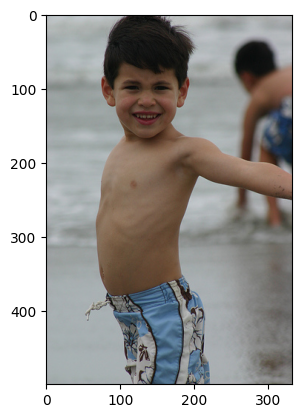

In [35]:
genrate_caption('/content/flickr8k/Images/106490881_5a2dd9b7bd.jpg')

Actual
start man in black is sitting next to modern art structure in front of glass building end
start man sits and reads newspaper by sculpture outside of an office building end
start man sits near large statue end
start man sitting in front of metal sculpture in front of building end
start the man with the backpack is sitting in buildings courtyard in front of an art sculpture reading end
Predicted start man is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is


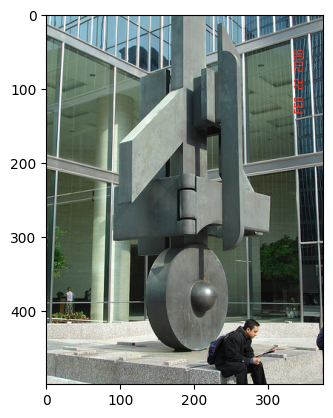

In [36]:
genrate_caption('/content/flickr8k/Images/103195344_5d2dc613a3.jpg')

Actual
start black dog jumping to catch rope toy end
start black dog playing fetch with ball of rope end
start black dog pounces to get rope toy end
start black dog running after his rope toy end
start large black dog is playing in grassy yard end
Predicted start dog running in the grass grass end


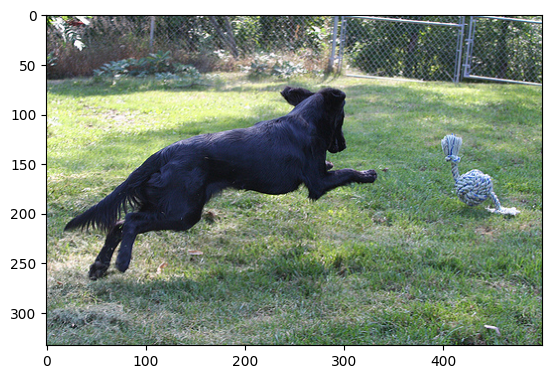

In [37]:
genrate_caption('/content/flickr8k/Images/1107246521_d16a476380.jpg')

Actual
start blonde girl is stepping on vertical logs in the sand end
start little girl is walking along line of logs on sandy beach end
start young girl balances on wooden pylons at the beach end
start young girl is walking on stumps on the beach next to the ocean end
start girl walking along the tops of wooden posts set into sand on beach end
Predicted start two boy on the on the the the end


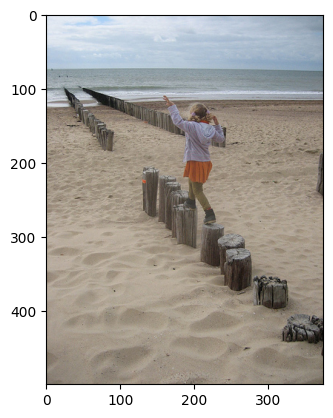

In [38]:
genrate_caption('/content/flickr8k/Images/1352410176_af6b139734.jpg')